# Quantum Wire Optics and Field Conversion

:::{abstract}
This tutorial covers the `qwoptics` module, which handles the interface between the macroscopic Maxwell fields (propagation space) and the microscopic quantum wire fields. We demonstrate field projection, polarization calculation, charge density computation, and linear susceptibility.
:::

## Theory

The quantum wire optics module bridges two spatial domains in the simulation:

1. **Propagation Space ($\mathbf{R}$)**: The macroscopic domain where optical pulses propagate over distances much larger than the wire dimensions.
2. **Quantum Wire Space ($\mathbf{r}$)**: The microscopic domain confined by the wire potential, where quantum mechanical carrier dynamics occur.

### Field Projection

The transformation between these domains involves:

**Propagation to QW (`Prop2QW`):**
- Interpolates Maxwell fields from propagation grid to QW grid
- Applies quantum wire window function to confine fields to wire region
- Performs FFT to convert from real space to momentum space

**QW to Propagation (`QW2Prop`):**
- Inverse FFT to convert from momentum space to real space
- Interpolates QW fields (polarization, charge density) back to propagation grid
- Normalizes charge densities for consistency

### Polarization Calculation

The quantum wire polarization is calculated from the density matrix:

$$
\mathbf{P}(\mathbf{r}) = \frac{2 \cdot \text{ehint}}{\text{area} \cdot L} \sum_{k_e, k_h} p_{cv}(k_h, k_e) \, \mathbf{d}_{vc}(k_h, k_e) \, e^{i(k_e - k_h)r} \, \phi_{QW}(\mathbf{r})
$$

where:
- $p_{cv}$ is the electron-hole coherence matrix
- $\mathbf{d}_{vc}$ are the dipole matrix elements
- $\phi_{QW}$ is the quantum wire window function
- `ehint` is the electron-hole overlap integral

### Charge Density Calculation

Electron and hole charge densities are computed from coherence matrices:

$$
\rho_e(\mathbf{r}) = \sum_{k_1, k_2} C(k_1, k_2) \, e^{-ik_1 r} e^{ik_2 r} \, \phi_{QW}(\mathbf{r})
$$

$$
\rho_h(\mathbf{r}) = \sum_{k_1, k_2} D^*(k_1, k_2) \, e^{-ik_1 r} e^{ik_2 r} \, \phi_{QW}(\mathbf{r})
$$

where $C$ and $D$ are electron-electron and hole-hole coherence matrices.

### Linear Susceptibility

The linear optical susceptibility is calculated as:

$$
\chi^{(1)}(\omega) = \frac{4 |d_{cv}|^2}{\epsilon_0 \cdot \text{area}} \frac{\Delta k}{2\pi} \sum_k \frac{E_e(k) + E_h(k)}{(E_e(k) + E_h(k) - \hbar\omega - i\hbar\gamma_{eh}) (E_e(k) + E_h(k) + \hbar\omega + i\hbar\gamma_{eh})}
$$

## Setup and Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import e as e0, hbar, c, epsilon_0 as eps0
import pulsesuite.PSTD3D.qwoptics as qwoptics

# Physical parameters (GaAs quantum wire)
L_wire = 100e-9        # Wire length: 100 nm
area = 1e-14           # Wire cross-sectional area: 10 nm²
gap = 1.42 * e0        # Band gap: 1.42 eV
dcv = 1e-29 + 0j       # Dipole moment: 1e-29 C·m
ehint = 0.8            # Electron-hole overlap integral

# Grid parameters
N_prop = 256           # Propagation space grid points
N_qw = 128             # Quantum wire space grid points
N_k = 64               # Momentum space grid points

# Propagation space grid (macroscopic)
R_prop = np.linspace(-500e-9, 500e-9, N_prop)  # 1 μm total window

# Quantum wire space grid (microscopic)
r_wire = np.linspace(-L_wire/2, L_wire/2, N_qw)

# Momentum grids
kmax = 1e8             # Maximum momentum (1/m)
kr = np.linspace(-kmax, kmax, N_k)
Qr = np.linspace(-kmax, kmax, N_qw)  # Momentum grid for FFT

# Electron and hole energies (parabolic bands)
m_e = 0.067 * 9.109e-31  # Electron effective mass (GaAs)
m_h = 0.45 * 9.109e-31   # Hole effective mass (GaAs)
Ee = hbar**2 * kr**2 / (2 * m_e)
Eh = hbar**2 * kr**2 / (2 * m_h)

print(f"Propagation domain: {R_prop.min()*1e9:.1f} to {R_prop.max()*1e9:.1f} nm")
print(f"Wire domain: {r_wire.min()*1e9:.1f} to {r_wire.max()*1e9:.1f} nm")
print(f"Momentum grid: {kr.min()/1e8:.2f} to {kr.max()/1e8:.2f} (10^8 m^-1)")

Propagation domain: -500.0 to 500.0 nm
Wire domain: -50.0 to 50.0 nm
Momentum grid: -1.00 to 1.00 (10^8 m^-1)


## Quantum Wire Window

The window function confines fields to the wire region. Let's calculate and visualize it:

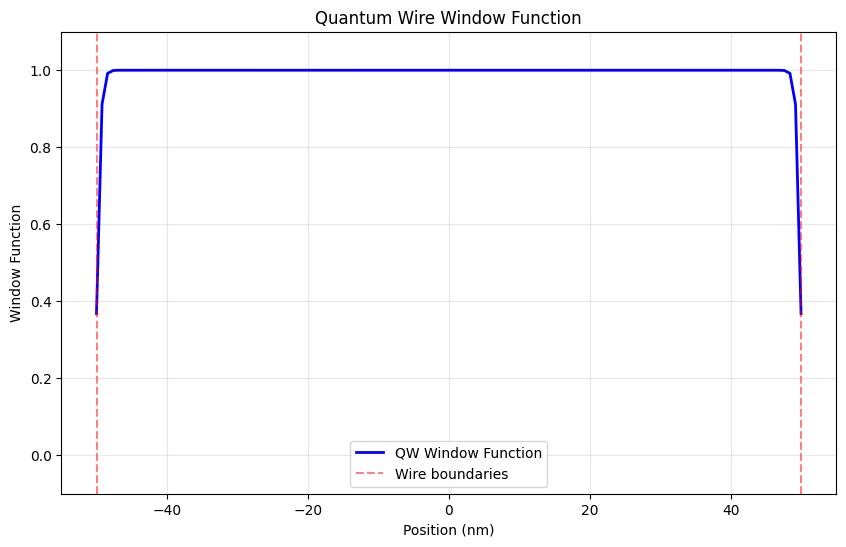

Window function: exp(-(r/(L/2))^150)
Window is 1 inside wire, decays rapidly outside


In [2]:
# Calculate quantum wire window function
qwoptics.CalcQWWindow(r_wire, L_wire)

# Access the window (stored in module-level variable)
# Note: In actual usage, this is set by InitializeQWOptics
window = qwoptics._QWWindow

# Visualize window function
plt.figure(figsize=(10, 6))
plt.plot(r_wire*1e9, window, 'b-', linewidth=2, label='QW Window Function')
plt.axvline(-L_wire/2*1e9, color='r', linestyle='--', alpha=0.5, label='Wire boundaries')
plt.axvline(L_wire/2*1e9, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Position (nm)')
plt.ylabel('Window Function')
plt.title('Quantum Wire Window Function')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-0.1, 1.1)
plt.show()

print(f"Window function: exp(-(r/(L/2))^150)")
print(f"Window is 1 inside wire, decays rapidly outside")

## Initialization and Dipole Matrices

Before using polarization and charge density functions, we must initialize the module:

QW optics module initialized
Dipole matrices shape: (64, 64)
Phase factor matrices shape: (64, 128)
Window function length: 128


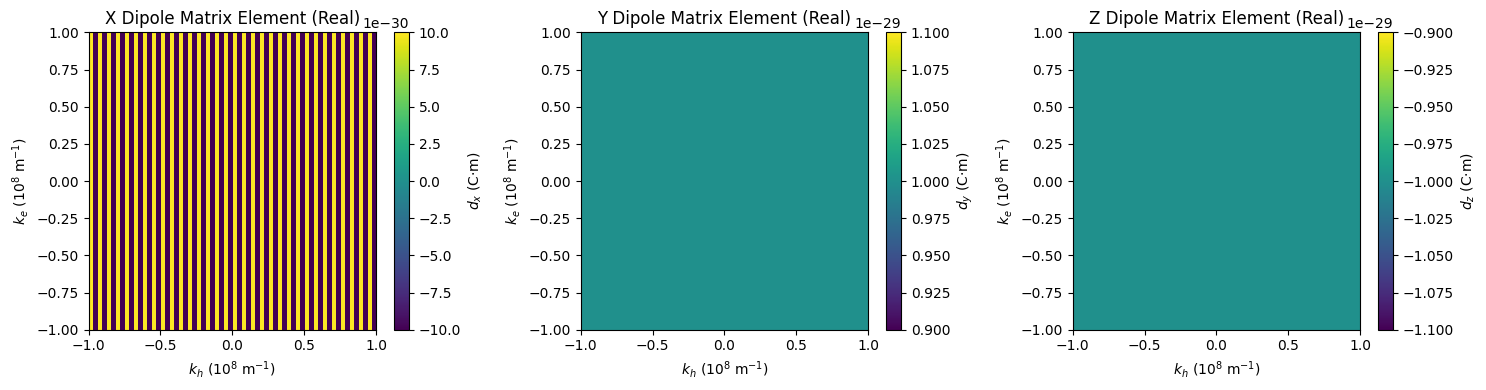

In [3]:
# Initialize QW optics module
# This sets up window function, phase factors, and dipole matrices
qwoptics.InitializeQWOptics(
    RR=r_wire,      # Spatial coordinate array
    L=L_wire,       # Wire length
    dcv=dcv,        # Dipole moment
    kr=kr,          # Momentum coordinate array
    Qr=Qr,          # Momentum array (for compatibility)
    Ee=Ee,          # Electron energies
    Eh=Eh,          # Hole energies
    ehint=ehint,    # Electron-hole overlap integral
    area=area,      # Wire area
    gap=gap         # Band gap (for compatibility)
)

print("QW optics module initialized")
print(f"Dipole matrices shape: {qwoptics._Xcv0.shape}")
print(f"Phase factor matrices shape: {qwoptics._Expikr.shape}")
print(f"Window function length: {len(qwoptics._QWWindow)}")

# Visualize dipole matrix elements
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# X component
im1 = axes[0].imshow(np.real(qwoptics._Xcv0), aspect='auto', origin='lower',
                    extent=[kr.min()/1e8, kr.max()/1e8, kr.min()/1e8, kr.max()/1e8])
axes[0].set_xlabel('$k_h$ ($10^8$ m$^{-1}$)')
axes[0].set_ylabel('$k_e$ ($10^8$ m$^{-1}$)')
axes[0].set_title('X Dipole Matrix Element (Real)')
plt.colorbar(im1, ax=axes[0], label='$d_x$ (C·m)')

# Y component
im2 = axes[1].imshow(np.real(qwoptics._Ycv0), aspect='auto', origin='lower',
                    extent=[kr.min()/1e8, kr.max()/1e8, kr.min()/1e8, kr.max()/1e8])
axes[1].set_xlabel('$k_h$ ($10^8$ m$^{-1}$)')
axes[1].set_ylabel('$k_e$ ($10^8$ m$^{-1}$)')
axes[1].set_title('Y Dipole Matrix Element (Real)')
plt.colorbar(im2, ax=axes[1], label='$d_y$ (C·m)')

# Z component
im3 = axes[2].imshow(np.real(qwoptics._Zcv0), aspect='auto', origin='lower',
                    extent=[kr.min()/1e8, kr.max()/1e8, kr.min()/1e8, kr.max()/1e8])
axes[2].set_xlabel('$k_h$ ($10^8$ m$^{-1}$)')
axes[2].set_ylabel('$k_e$ ($10^8$ m$^{-1}$)')
axes[2].set_title('Z Dipole Matrix Element (Real)')
plt.colorbar(im3, ax=axes[2], label='$d_z$ (C·m)')

plt.tight_layout()
plt.show()

## Field Projection: Propagation to QW

Now let's demonstrate field projection from propagation space to QW space:

Field projection complete
Fields are now in momentum space (after FFT)
Ex_wire shape: (128,), dtype: complex128


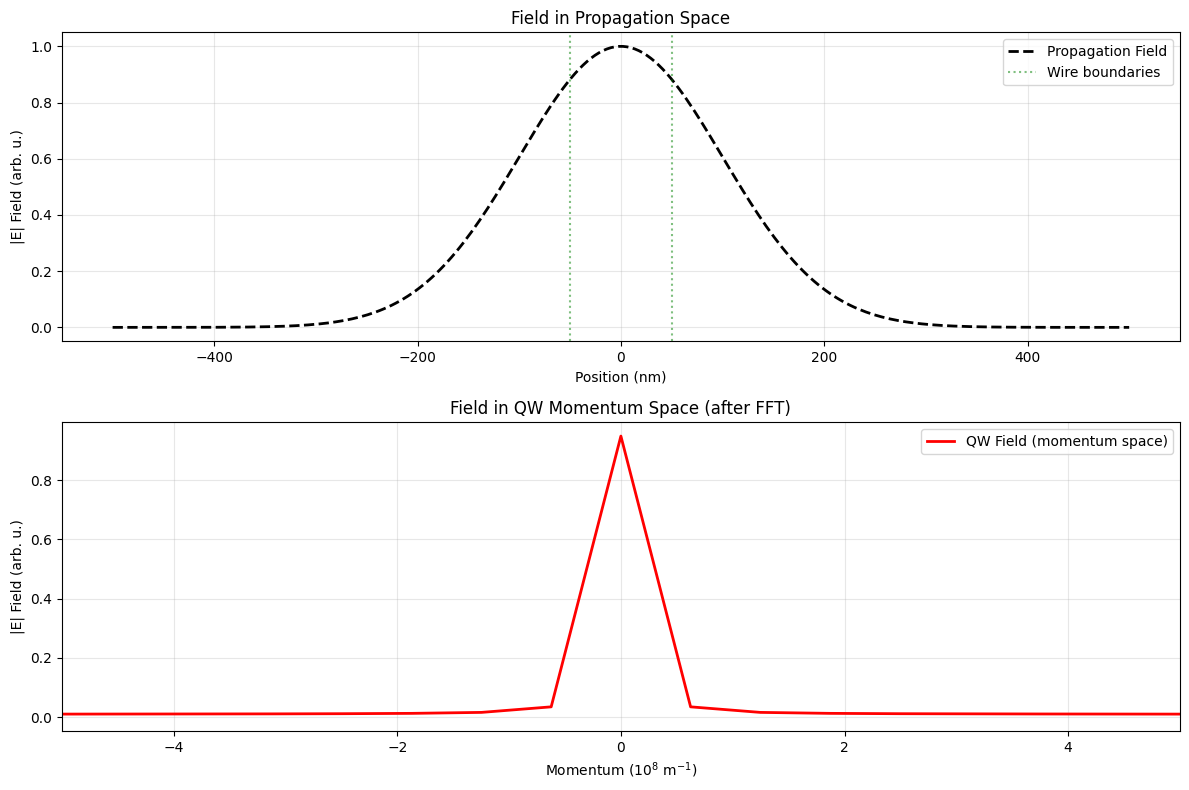

In [4]:
# Create a Gaussian optical pulse in propagation space
sigma = 100e-9  # Pulse width: 100 nm
center = 0.0     # Pulse center

Ex_prop = np.exp(-(R_prop - center)**2 / (2*sigma**2)) + 0j
Ey_prop = np.zeros_like(Ex_prop)
Ez_prop = np.zeros_like(Ex_prop)
V_prop = np.zeros_like(Ex_prop)

# Arrays for QW fields (will be modified in-place)
Ex_wire = np.zeros_like(r_wire, dtype=complex)
Ey_wire = np.zeros_like(r_wire, dtype=complex)
Ez_wire = np.zeros_like(r_wire, dtype=complex)
V_wire = np.zeros_like(r_wire, dtype=complex)

# Perform projection: Propagation to QW
# Note: Edc is a float parameter (currently unused, set to 0.0)
qwoptics.Prop2QW(
    RR=R_prop,      # Propagation spatial array
    Exx=Ex_prop,    # Propagation X field
    Eyy=Ey_prop,    # Propagation Y field
    Ezz=Ez_prop,    # Propagation Z field
    Vrr=V_prop,     # Propagation potential
    Edc=0.0,        # DC field (float, currently unused)
    R=r_wire,       # QW spatial array
    Ex=Ex_wire,     # QW X field (output)
    Ey=Ey_wire,     # QW Y field (output)
    Ez=Ez_wire,     # QW Z field (output)
    Vr=V_wire,      # QW potential (output)
    t=0.0,          # Time
    xxx=1            # Time index
)

print("Field projection complete")
print(f"Fields are now in momentum space (after FFT)")
print(f"Ex_wire shape: {Ex_wire.shape}, dtype: {Ex_wire.dtype}")

# Visualize field projection
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Real space comparison (before FFT in Prop2QW, we see the windowed field)
# Note: Prop2QW performs FFT, so Ex_wire is in momentum space
# For visualization, we'll show the magnitude in momentum space
axes[0].plot(R_prop*1e9, np.abs(Ex_prop), 'k--', linewidth=2, label='Propagation Field')
axes[0].axvline(-L_wire/2*1e9, color='g', linestyle=':', alpha=0.5, label='Wire boundaries')
axes[0].axvline(L_wire/2*1e9, color='g', linestyle=':', alpha=0.5)
axes[0].set_xlabel('Position (nm)')
axes[0].set_ylabel('|E| Field (arb. u.)')
axes[0].set_title('Field in Propagation Space')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Momentum space (after FFT)
Qr_plot = np.fft.fftshift(np.fft.fftfreq(len(r_wire), r_wire[1] - r_wire[0])) * 2 * np.pi
Ex_wire_shifted = np.fft.fftshift(Ex_wire)
axes[1].plot(Qr_plot/1e8, np.abs(Ex_wire_shifted), 'r-', linewidth=2, label='QW Field (momentum space)')
axes[1].set_xlabel('Momentum ($10^8$ m$^{-1}$)')
axes[1].set_ylabel('|E| Field (arb. u.)')
axes[1].set_title('Field in QW Momentum Space (after FFT)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(-5, 5)

plt.tight_layout()
plt.show()

## Polarization Calculation

Calculate the quantum wire polarization from a coherence matrix:

/home/astavak/.pyenv/versions/3.10.16/envs/venv3.10/lib/python3.10/site-packages/numba_cuda/numba/cuda/dispatcher.py:690: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(errors.NumbaPerformanceWarning(msg))


Polarization calculation complete
Polarization arrays shape: (128,)
Px magnitude range: 5.96e-28 to 1.89e-12


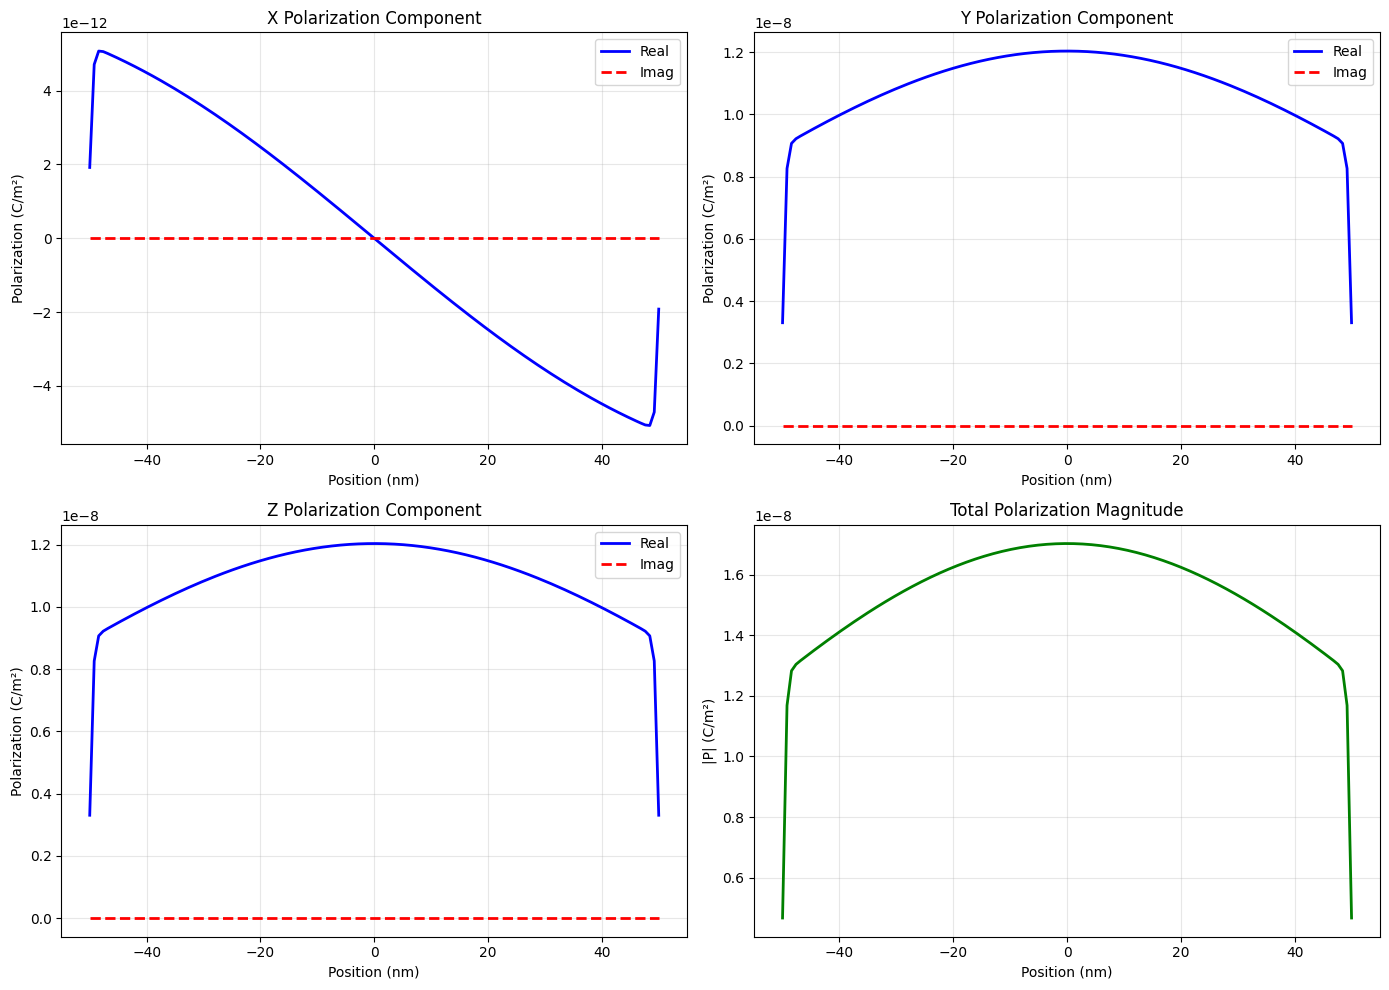

In [5]:
# Create a simple coherence matrix (electron-hole coherence)
# In real simulations, this comes from solving the SBEs
p_cv = np.zeros((N_k, N_k), dtype=complex)

# Create a simple Gaussian coherence centered at k=0
k_center = N_k // 2
sigma_k = 5
for ke in range(N_k):
    for kh in range(N_k):
        k_diff = (ke - kh) - (k_center - k_center)
        p_cv[kh, ke] = np.exp(-k_diff**2 / (2*sigma_k**2)) * (1e-3 + 1j*1e-4)

# Arrays for polarization (will be modified in-place)
Px = np.zeros_like(r_wire, dtype=complex)
Py = np.zeros_like(r_wire, dtype=complex)
Pz = np.zeros_like(r_wire, dtype=complex)

# Calculate polarization
qwoptics.QWPolarization3(
    y=r_wire,       # Spatial coordinate array
    ky=kr,          # Momentum coordinate array
    p=p_cv,         # Density matrix (coherence)
    ehint=ehint,    # Electron-hole overlap integral
    area=area,      # Wire area
    L=L_wire,       # Wire length
    Px=Px,          # X polarization (output)
    Py=Py,          # Y polarization (output)
    Pz=Pz,          # Z polarization (output)
    xxx=1,          # Time index
    w=1             # Wire index
)

print("Polarization calculation complete")
print(f"Polarization arrays shape: {Px.shape}")
print(f"Px magnitude range: {np.abs(Px).min():.2e} to {np.abs(Px).max():.2e}")

# Visualize polarization components
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Real space polarization (inverse FFT to get back to real space)
# Note: QWPolarization3 performs FFT, so Px is in momentum space
# For visualization, we inverse FFT
from pulsesuite.PSTD3D.usefulsubs import iFFTG

Px_r = Px.copy()
Py_r = Py.copy()
Pz_r = Pz.copy()

iFFTG(Px_r)
iFFTG(Py_r)
iFFTG(Pz_r)

# X component
axes[0, 0].plot(r_wire*1e9, np.real(Px_r), 'b-', linewidth=2, label='Real')
axes[0, 0].plot(r_wire*1e9, np.imag(Px_r), 'r--', linewidth=2, label='Imag')
axes[0, 0].set_xlabel('Position (nm)')
axes[0, 0].set_ylabel('Polarization (C/m²)')
axes[0, 0].set_title('X Polarization Component')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Y component
axes[0, 1].plot(r_wire*1e9, np.real(Py_r), 'b-', linewidth=2, label='Real')
axes[0, 1].plot(r_wire*1e9, np.imag(Py_r), 'r--', linewidth=2, label='Imag')
axes[0, 1].set_xlabel('Position (nm)')
axes[0, 1].set_ylabel('Polarization (C/m²)')
axes[0, 1].set_title('Y Polarization Component')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Z component
axes[1, 0].plot(r_wire*1e9, np.real(Pz_r), 'b-', linewidth=2, label='Real')
axes[1, 0].plot(r_wire*1e9, np.imag(Pz_r), 'r--', linewidth=2, label='Imag')
axes[1, 0].set_xlabel('Position (nm)')
axes[1, 0].set_ylabel('Polarization (C/m²)')
axes[1, 0].set_title('Z Polarization Component')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Total magnitude
P_tot = np.sqrt(np.abs(Px_r)**2 + np.abs(Py_r)**2 + np.abs(Pz_r)**2)
axes[1, 1].plot(r_wire*1e9, P_tot, 'g-', linewidth=2)
axes[1, 1].set_xlabel('Position (nm)')
axes[1, 1].set_ylabel('|P| (C/m²)')
axes[1, 1].set_title('Total Polarization Magnitude')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Charge Density Calculation

Calculate electron and hole charge densities from coherence matrices:

/home/astavak/.pyenv/versions/3.10.16/envs/venv3.10/lib/python3.10/site-packages/numba_cuda/numba/cuda/dispatcher.py:690: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(errors.NumbaPerformanceWarning(msg))


Charge density calculation complete
Electron density range: 5.59e-09 to 6.81e+06 m^-3
Hole density range: 5.59e-09 to 6.81e+06 m^-3


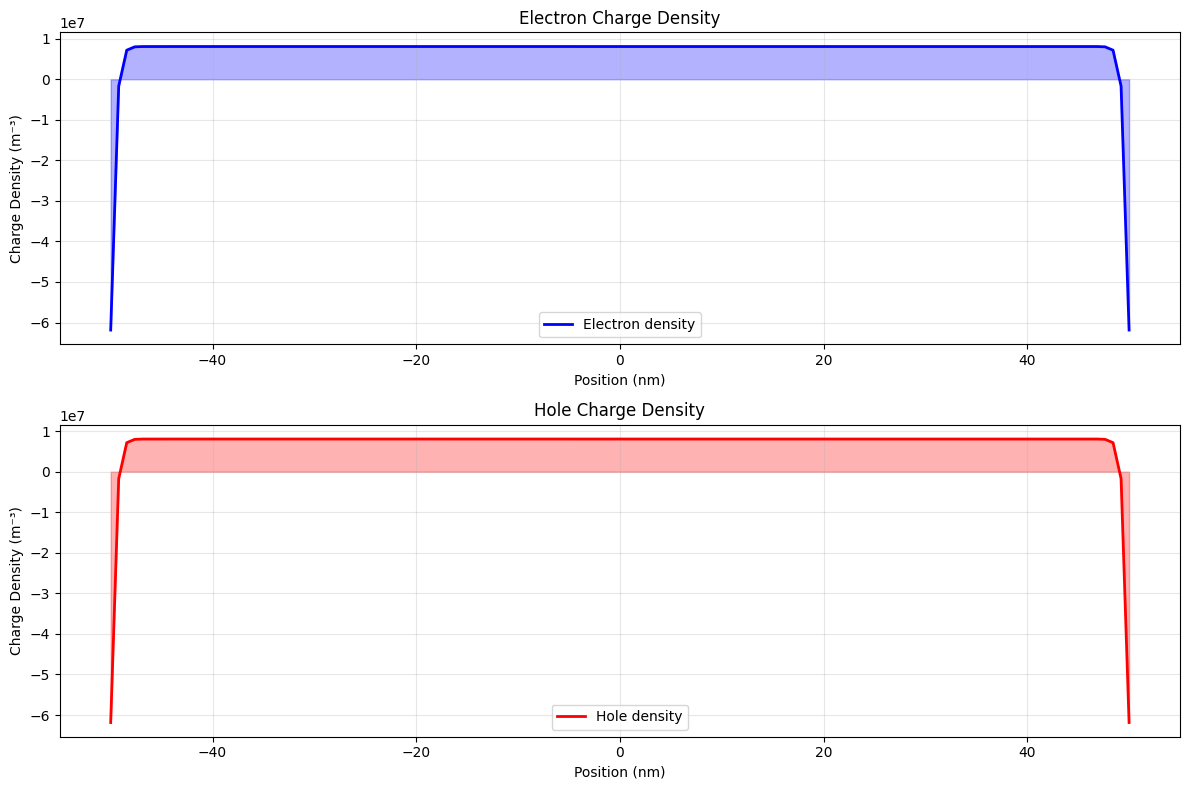

In [6]:
# Create coherence matrices (electron-electron and hole-hole)
# In real simulations, these come from solving the SBEs
CC = np.zeros((N_k, N_k), dtype=complex)  # Electron-electron coherence
DD = np.zeros((N_k, N_k), dtype=complex)  # Hole-hole coherence

# Create simple diagonal coherence (carriers at k=0)
k_center = N_k // 2
for k in range(N_k):
    CC[k, k] = 0.1 * np.exp(-((k - k_center) / 5)**2)  # Electron occupation
    DD[k, k] = 0.1 * np.exp(-((k - k_center) / 5)**2)  # Hole occupation

# Occupation numbers (for normalization)
ne = np.diag(CC).real.copy()
nh = np.diag(DD).real.copy()

# Momentum difference matrix (simplified - identity mapping)
kkp = np.zeros((N_k, N_k), dtype=int)
for k1 in range(N_k):
    for k2 in range(N_k):
        kkp[k1, k2] = k2 - k1  # Simple difference

# Arrays for charge densities (will be modified in-place)
re = np.zeros_like(r_wire, dtype=complex)
rh = np.zeros_like(r_wire, dtype=complex)

# Calculate charge densities
qwoptics.QWRho5(
    Qr=Qr,          # QW momentum array
    kr=kr,          # QW momentum array
    R=r_wire,       # QW spatial coordinate array
    L=L_wire,       # Wire length
    kkp=kkp,        # Momentum difference index matrix
    p=p_cv,         # Density matrix (unused, for compatibility)
    CC=CC,          # Electron-electron coherence matrix
    DD=DD,          # Hole-hole coherence matrix
    ne=ne,          # Electron occupation numbers
    nh=nh,          # Hole occupation numbers
    re=re,          # Electron charge density (output)
    rh=rh,          # Hole charge density (output)
    xxx=1,          # Time index
    jjj=1           # Additional index (unused)
)

print("Charge density calculation complete")
print(f"Electron density range: {np.abs(re).min():.2e} to {np.abs(re).max():.2e} m^-3")
print(f"Hole density range: {np.abs(rh).min():.2e} to {np.abs(rh).max():.2e} m^-3")

# Visualize charge densities
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Inverse FFT to get real space densities
re_r = re.copy()
rh_r = rh.copy()
iFFTG(re_r)
iFFTG(rh_r)

# Electron density
axes[0].plot(r_wire*1e9, np.real(re_r), 'b-', linewidth=2, label='Electron density')
axes[0].fill_between(r_wire*1e9, 0, np.real(re_r), alpha=0.3, color='blue')
axes[0].set_xlabel('Position (nm)')
axes[0].set_ylabel('Charge Density (m⁻³)')
axes[0].set_title('Electron Charge Density')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Hole density
axes[1].plot(r_wire*1e9, np.real(rh_r), 'r-', linewidth=2, label='Hole density')
axes[1].fill_between(r_wire*1e9, 0, np.real(rh_r), alpha=0.3, color='red')
axes[1].set_xlabel('Position (nm)')
axes[1].set_ylabel('Charge Density (m⁻³)')
axes[1].set_title('Hole Charge Density')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Field Projection: QW to Propagation

Convert QW fields back to propagation space:

Field projection to propagation space complete


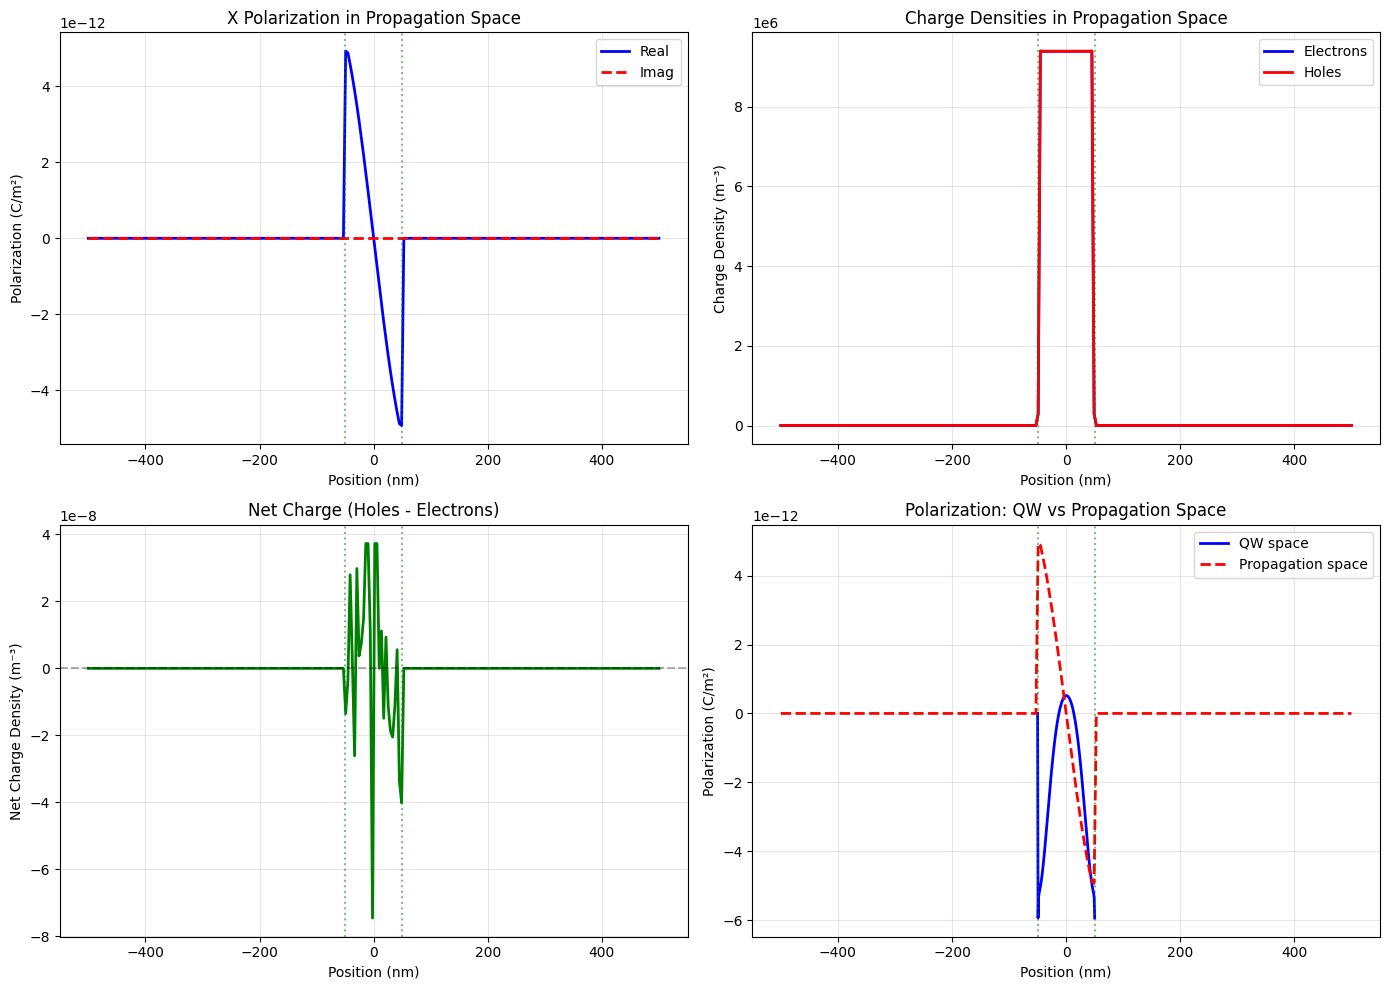

In [7]:
# Prepare arrays for propagation space outputs
Pxx = np.zeros_like(R_prop, dtype=complex)
Pyy = np.zeros_like(R_prop, dtype=complex)
Pzz = np.zeros_like(R_prop, dtype=complex)
RhoE = np.zeros_like(R_prop, dtype=complex)
RhoH = np.zeros_like(R_prop, dtype=complex)

# Convert QW fields back to propagation space
qwoptics.QW2Prop(
    r=r_wire,       # QW spatial array
    Qr=Qr,          # QW momentum array
    Ex=Ex_wire,     # QW X field (modified in-place)
    Ey=Ey_wire,     # QW Y field (modified in-place)
    Ez=Ez_wire,     # QW Z field (modified in-place)
    Vr=V_wire,      # QW potential (modified in-place)
    Px=Px,          # QW X polarization (modified in-place)
    Py=Py,          # QW Y polarization (modified in-place)
    Pz=Pz,          # QW Z polarization (modified in-place)
    re=re,          # QW electron density (modified in-place)
    rh=rh,          # QW hole density (modified in-place)
    RR=R_prop,      # Propagation spatial array
    Pxx=Pxx,        # Propagation X polarization (output)
    Pyy=Pyy,        # Propagation Y polarization (output)
    Pzz=Pzz,        # Propagation Z polarization (output)
    RhoE=RhoE,      # Propagation electron density (output)
    RhoH=RhoH,      # Propagation hole density (output)
    w=1,            # Wire index
    xxx=1,          # Time index
    WriteFields=False,  # Don't write to files
    Plasmonics=True     # Normalize charge densities
)

print("Field projection to propagation space complete")

# Visualize round-trip projection
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Polarization components
axes[0, 0].plot(R_prop*1e9, np.real(Pxx), 'b-', linewidth=2, label='Real')
axes[0, 0].plot(R_prop*1e9, np.imag(Pxx), 'r--', linewidth=2, label='Imag')
axes[0, 0].set_xlabel('Position (nm)')
axes[0, 0].set_ylabel('Polarization (C/m²)')
axes[0, 0].set_title('X Polarization in Propagation Space')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(-L_wire/2*1e9, color='g', linestyle=':', alpha=0.5)
axes[0, 0].axvline(L_wire/2*1e9, color='g', linestyle=':', alpha=0.5)

# Charge densities
axes[0, 1].plot(R_prop*1e9, np.real(RhoE), 'b-', linewidth=2, label='Electrons')
axes[0, 1].plot(R_prop*1e9, np.real(RhoH), 'r-', linewidth=2, label='Holes')
axes[0, 1].set_xlabel('Position (nm)')
axes[0, 1].set_ylabel('Charge Density (m⁻³)')
axes[0, 1].set_title('Charge Densities in Propagation Space')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axvline(-L_wire/2*1e9, color='g', linestyle=':', alpha=0.5)
axes[0, 1].axvline(L_wire/2*1e9, color='g', linestyle=':', alpha=0.5)

# Net charge
axes[1, 0].plot(R_prop*1e9, np.real(RhoH - RhoE), 'g-', linewidth=2)
axes[1, 0].axhline(0, color='k', linestyle='--', alpha=0.3)
axes[1, 0].set_xlabel('Position (nm)')
axes[1, 0].set_ylabel('Net Charge Density (m⁻³)')
axes[1, 0].set_title('Net Charge (Holes - Electrons)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axvline(-L_wire/2*1e9, color='g', linestyle=':', alpha=0.5)
axes[1, 0].axvline(L_wire/2*1e9, color='g', linestyle=':', alpha=0.5)

# Comparison: QW vs Propagation polarization
# Get QW polarization in real space for comparison
Px_qw_rs = Px.copy()
iFFTG(Px_qw_rs)
axes[1, 1].plot(r_wire*1e9, np.real(Px_qw_rs), 'b-', linewidth=2, label='QW space')
axes[1, 1].plot(R_prop*1e9, np.real(Pxx), 'r--', linewidth=2, label='Propagation space')
axes[1, 1].set_xlabel('Position (nm)')
axes[1, 1].set_ylabel('Polarization (C/m²)')
axes[1, 1].set_title('Polarization: QW vs Propagation Space')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axvline(-L_wire/2*1e9, color='g', linestyle=':', alpha=0.5)
axes[1, 1].axvline(L_wire/2*1e9, color='g', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

## Linear Susceptibility

Calculate the linear optical susceptibility as a function of wavelength:

Susceptibility calculation complete
Susceptibility range: 4.80e-10 to 1.33e-09


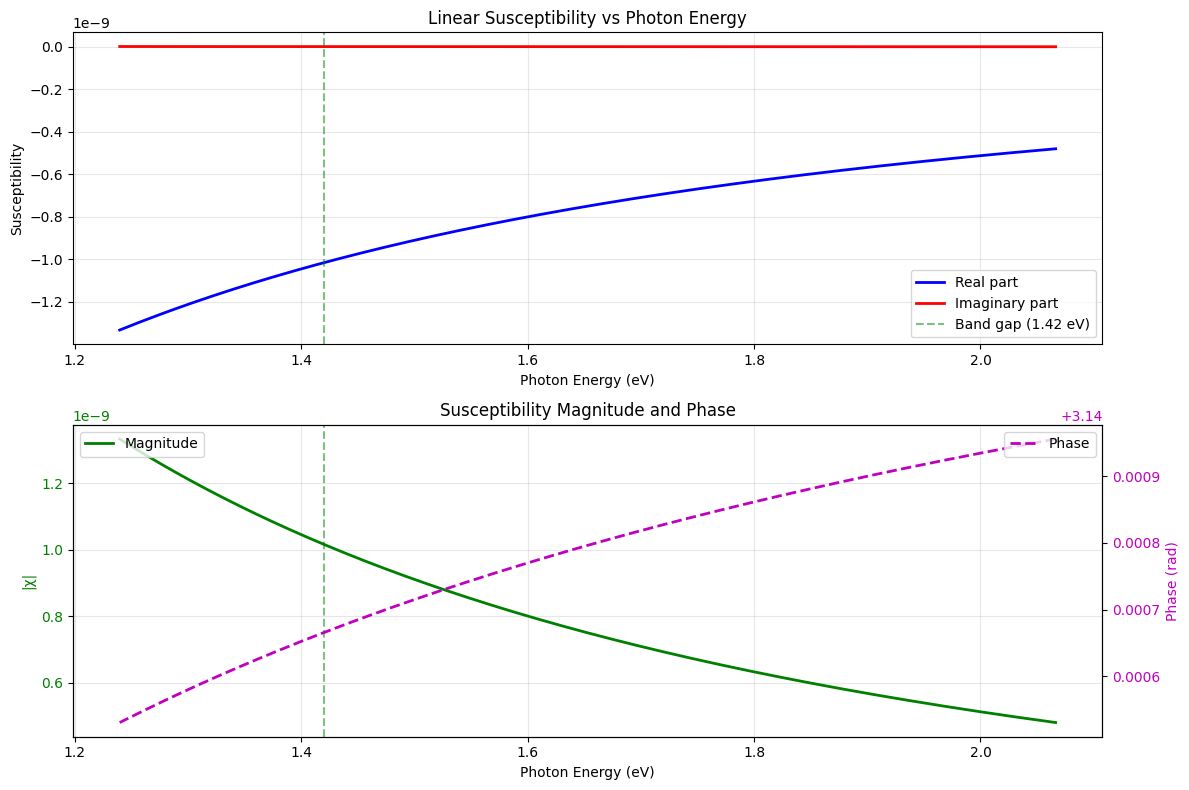

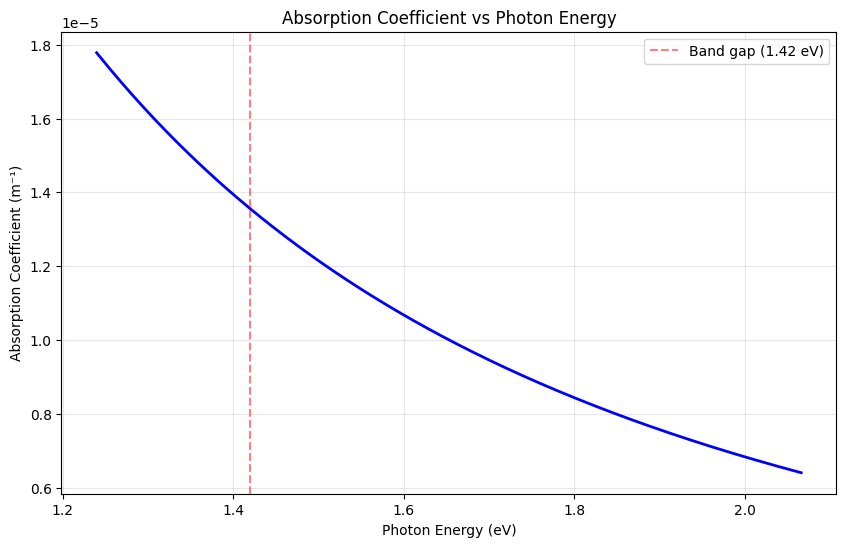

In [8]:
# Wavelength range for susceptibility calculation
wavelengths = np.linspace(600e-9, 1000e-9, 200)  # 600-1000 nm
dky = kr[1] - kr[0]  # Momentum step
geh = 1e12  # Electron-hole dephasing rate (1/s)

# Calculate susceptibility for each wavelength
chi1 = np.zeros(len(wavelengths), dtype=complex)

for i, lam in enumerate(wavelengths):
    chi1[i] = qwoptics.QWChi1(
        lam=lam,        # Wavelength
        dky=dky,        # Momentum step
        Ee=Ee,          # Electron energies
        Eh=Eh,          # Hole energies
        area=area,      # Wire area
        geh=geh,        # Dephasing rate
        dcv=dcv         # Dipole moment
    )

print("Susceptibility calculation complete")
print(f"Susceptibility range: {np.abs(chi1).min():.2e} to {np.abs(chi1).max():.2e}")

# Convert wavelengths to photon energies
photon_energy = hbar * 2 * np.pi * c / wavelengths / e0  # eV

# Visualize susceptibility
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Real and imaginary parts
axes[0].plot(photon_energy, np.real(chi1), 'b-', linewidth=2, label='Real part')
axes[0].plot(photon_energy, np.imag(chi1), 'r-', linewidth=2, label='Imaginary part')
axes[0].set_xlabel('Photon Energy (eV)')
axes[0].set_ylabel('Susceptibility')
axes[0].set_title('Linear Susceptibility vs Photon Energy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axvline(gap/e0, color='g', linestyle='--', alpha=0.5, label=f'Band gap ({gap/e0:.2f} eV)')
axes[0].legend()

# Magnitude and phase
axes[1].plot(photon_energy, np.abs(chi1), 'g-', linewidth=2, label='Magnitude')
ax2 = axes[1].twinx()
ax2.plot(photon_energy, np.angle(chi1), 'm--', linewidth=2, label='Phase')
axes[1].set_xlabel('Photon Energy (eV)')
axes[1].set_ylabel('|χ|', color='g')
ax2.set_ylabel('Phase (rad)', color='m')
axes[1].set_title('Susceptibility Magnitude and Phase')
axes[1].tick_params(axis='y', labelcolor='g')
ax2.tick_params(axis='y', labelcolor='m')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(gap/e0, color='g', linestyle='--', alpha=0.5)
axes[1].legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Calculate absorption coefficient from imaginary part
# alpha = (2*omega/c) * Im(chi)
omega = 2 * np.pi * c / wavelengths
alpha = 2 * omega / c * np.imag(chi1)

plt.figure(figsize=(10, 6))
plt.plot(photon_energy, alpha, 'b-', linewidth=2)
plt.xlabel('Photon Energy (eV)')
plt.ylabel('Absorption Coefficient (m⁻¹)')
plt.title('Absorption Coefficient vs Photon Energy')
plt.grid(True, alpha=0.3)
plt.axvline(gap/e0, color='r', linestyle='--', alpha=0.5, label=f'Band gap ({gap/e0:.2f} eV)')
plt.legend()
plt.show()

## Assumptions and Parameter Choices

This section explains the assumptions and rationale behind the parameter values chosen for this example.

### Material Parameters (GaAs)

**Effective masses:**
- `m_e = 0.067 * m_0`: Electron effective mass for GaAs (bulk value ~0.067m₀)
- `m_h = 0.45 * m_0`: Heavy hole effective mass for GaAs (bulk value ~0.45m₀)
- **Rationale**: Standard GaAs bulk values. Quantum confinement may modify these, but bulk values are reasonable for demonstration.

**Band gap:**
- `gap = 1.42 * e0`: GaAs band gap at room temperature (~1.42 eV)
- **Rationale**: Standard value for bulk GaAs. Quantum confinement increases the gap, but we use bulk value for simplicity.

**Dipole moment:**
- `dcv = 1e-29 C·m`: Interband dipole moment
- **Rationale**: Typical order of magnitude for semiconductor interband transitions. Actual value depends on material and confinement.

**Dielectric constant:**
- `epsr = 9.1`: Relative permittivity (set in module, not shown in example)
- **Rationale**: GaAs relative permittivity at optical frequencies.

### Wire Dimensions

**Wire length:**
- `L_wire = 100e-9`: 100 nm wire length
- **Rationale**: Representative of quantum wire dimensions. Long enough to show confinement effects, short enough for computational efficiency.

**Wire area:**
- `area = 1e-14 m²`: 10 nm² cross-sectional area
- **Rationale**: Typical quantum wire cross-section. Affects density of states and Coulomb interactions.

**Overlap integral:**
- `ehint = 0.8`: Electron-hole overlap integral
- **Rationale**: Simplified value. In reality, this depends on confinement wavefunctions and should be calculated from the actual eigenstates.

### Grid Parameters

**Spatial grids:**
- `N_prop = 256`: Propagation space grid points
- `N_qw = 128`: Quantum wire space grid points
- **Rationale**: Propagation space needs finer grid to resolve pulse propagation. QW space grid should be sufficient to resolve wire confinement.

**Momentum grid:**
- `N_k = 64`: Momentum space grid points
- `kmax = 1e8 m⁻¹`: Maximum momentum
- **Rationale**: Should cover relevant k-space for carriers. In real simulations, this is determined by energy cutoff.

### Simplifications

**Coherence matrices:**
- Static, simplified coherence matrices (Gaussian distributions)
- **Reality**: In full simulations, these evolve according to the SBEs and depend on field strength, Coulomb interactions, phonons, etc.

**Energy bands:**
- Parabolic bands: $E(k) = \hbar^2 k^2 / (2m)$
- **Reality**: Quantum confinement modifies the band structure. Full calculations should use actual eigenenergies.

**Dephasing:**
- Constant dephasing rate `geh = 1e12 s⁻¹`
- **Reality**: Dephasing depends on temperature, carrier density, and momentum. Should be calculated from phonon and carrier-carrier scattering.

**Window function:**
- Simple exponential: $\exp(-(r/(L/2))^{150})$
- **Reality**: Actual confinement potential may have different shape. Window function is a computational convenience.

### Limitations

:::{warning}
**Important Limitations:**
1. **Static distributions**: Carrier distributions are static. Full simulations require coupling with the SBE solver.
2. **Simplified coherence**: Coherence matrices are simplified. Real calculations require solving the full SBEs.
3. **No Coulomb effects**: This example doesn't include Coulomb interactions. Use the `coulomb` module for realistic calculations.
4. **No phonon effects**: Phonon scattering is not included. Use the `phonons` module for temperature-dependent effects.
5. **Single wire**: Example shows single wire. Multi-wire systems require additional considerations.
6. **Linear response**: Susceptibility calculation assumes linear response. Nonlinear effects require full SBE solution.
:::

### When to Use More Realistic Approaches

- **Full SBE simulations**: When studying dynamics, use the `SBEs` module which couples all effects.
- **Coulomb interactions**: For many-body effects, include the `coulomb` module.
- **Phonon scattering**: For temperature-dependent effects, include the `phonons` module.
- **DC field transport**: For carrier transport, include the `dcfield` module.
- **Emission**: For photoluminescence, include the `emission` module.

## Summary

This tutorial demonstrated the key functions of the `qwoptics` module:

1. **Field Projection**:
   - `Prop2QW`: Converts Maxwell fields from propagation space to QW space
   - `QW2Prop`: Converts QW fields back to propagation space

2. **Initialization**:
   - `InitializeQWOptics`: Sets up dipole matrices, phase factors, and window function
   - `CalcQWWindow`: Calculates quantum wire window function

3. **Polarization**:
   - `QWPolarization3`: Calculates quantum wire polarization from coherence matrix

4. **Charge Density**:
   - `QWRho5`: Calculates electron and hole charge densities from coherence matrices

5. **Linear Susceptibility**:
   - `QWChi1`: Calculates frequency-dependent linear optical susceptibility

The module provides the essential interface between macroscopic Maxwell propagation and microscopic quantum wire dynamics, enabling self-consistent simulations of light-matter interactions in quantum wire systems.